In [2]:
import os
import sys
import pickle

import pandas as pd
import numpy as np
from matplotlib.pyplot import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

from config import RESULTS, FIGURES
from code_.tools.plotting import *
from code_.model_activations.configs import model_cfg

y_lim = {'naturalscenes':0.45, 'majajhong': 0.65, 'things':0.15}

In [3]:
models_features_config = {
    'vit': {'multiplier': 196},
    'expansion': {'multiplier': 36},
    'fully_connected': {'multiplier': 1}
}

def load_and_prepare_data(model_name, multiplier, dataset, region):
    filepath = os.path.join(RESULTS, f'bootstrap-results-{model_name}-{dataset}-{region}.csv')
    df = pd.read_csv(filepath)
    df['model'] = model_name
    df['features'] = df['features'].apply(lambda x: int(x) * multiplier)
    df['score'] = df['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))

    return df

# Main results

In [4]:
# choose dataset and regions

DATASET = 'naturalscenes' 
region = 'ventral visual stream' # one of early visual stream, midventral visual stream, ventral visual stream

# DATASET = 'majajhong'
# region = 'IT' # one of V4,IT

# DATASET = 'things'
# region = 'V4' # one of "V1", "V2", "V3", "V4", "FFA", "PPA", "LOC


In [5]:
# Process each model
all_dfs = []
for model_name, config in models_features_config.items():
    features_list = model_cfg[DATASET]['models'][model_name]['features']
    df_model = load_and_prepare_data(model_name, config['multiplier'], DATASET, region)
    all_dfs.append(df_model)

# Combine all dataframes and reset index
df = pd.concat(all_dfs).reset_index(drop=True)

In [6]:
# alexnet data
df_alexnet = pd.read_csv(os.path.join(RESULTS, f'bootstrap-results-alexnet_trained-{DATASET}-{region}.csv'))
df_alexnet['score'] = df_alexnet['score'].apply(lambda x: float(x.replace("tensor(", "").replace(")", "")))


In [7]:
names ={'expansion':'Convolutional',
        'vit':'Transformer',
        'fully_connected':'Fully connected'}
palette ={'Convolutional':'royalblue',
          'Transformer':'palevioletred',
          'Fully connected':'darkviolet'}

df['model'] = df['model'].map(names)
df['color'] = df['model'].map(palette)

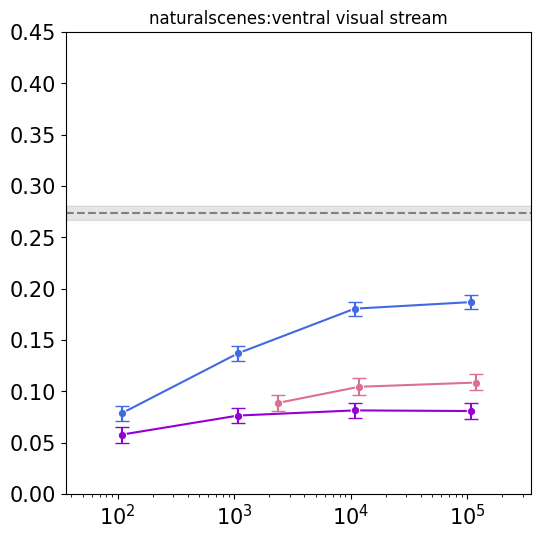

In [8]:
rcParams['figure.figsize'] = (6,6)  

# main plot
ax1 = sns.lineplot(data = df, x='features', y='score', hue='model', marker='o', palette = palette)
# adding error bars for the 95% confidence interval
for i in range(len(df)):
    plt.errorbar(df['features'][i], df['score'][i], 
                 yerr=[[df['score'][i] - df['lower'][i]], [df['upper'][i] - df['score'][i]]], 
                 fmt='none', capsize=5, color=df['color'][i])   
    
# alexnet 
plt.axhline(y=df_alexnet['score'][0], color='gray', linestyle='--', label='AlexNet')

# adding 95% confidence interval 
plt.fill_between(np.arange(df['features'].min()/3,df['features'].max()*3), 
                 df_alexnet['lower'], df_alexnet['upper'], color='gray', alpha=0.2)

plt.ylim(0,y_lim[DATASET])
plt.xlabel('')
plt.ylabel('')
plt.xlim(df['features'].min()/3,df['features'].max()*3)
plt.xticks(size=15)
plt.yticks(size=15)
ax1.set_xscale("log")  
plt.title(f'{DATASET}:{region}')      
ax1.legend(frameon=False,fontsize=12) if region == 'V1' else ax1.legend_.remove()
plt.savefig(os.path.join(FIGURES, f'figure_2_{DATASET}_{region}.png'), dpi=200) 
plt.show()

# Scaling effect

In [9]:
# Configurations for models and features
models_config = {
    'expansion': {'min_features': 108, 'max_features': 1080000},
    'fully_connected': {'min_features': 108, 'max_features': 1080000},
    'vit': {'min_features': 2352, 'max_features': 1176000}
}

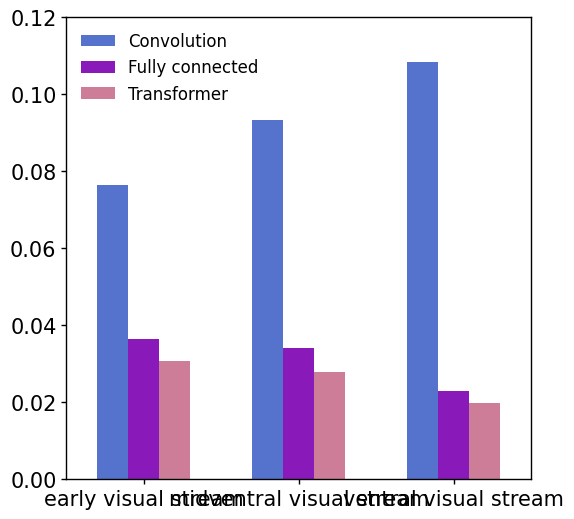

In [10]:
# Dataset dependent changes
if DATASET in ['naturalscenes', 'things']:
    models_config['expansion']['max_features']/=10 
    models_config['fully_connected']['max_features']/=10 
    models_config['vit']['max_features']/=10 

# Data initialization
ratios_dicts = {model: {'region':[], 'dataset':[], 'model':[], 'smallest model score':[], 'largest model score':[], 'difference':[]} for model in models_config}


# Loop through regions and models
for region in model_cfg[DATASET]['regions'][:4]:
    for model_name, config in models_config.items():
        df_model = load_and_prepare_data(model_name, models_features_config[model_name]['multiplier'], DATASET, region)
        smallest_score = float(df_model[df_model.features == config['min_features']]['score'].item())
        largest_score = float(df_model[df_model.features == config['max_features']]['score'].item())
        
        ratios_dicts[model_name]['region'].append(region)
        ratios_dicts[model_name]['dataset'].append(DATASET)
        ratios_dicts[model_name]['model'].append(model_name)
        ratios_dicts[model_name]['smallest model score'].append(smallest_score)
        ratios_dicts[model_name]['largest model score'].append(largest_score)
        ratios_dicts[model_name]['difference'].append(largest_score - smallest_score)

# Concatenate all dataframes
df = pd.concat([pd.DataFrame.from_dict(ratios_dicts[model]) for model in models_config]).reset_index(drop=True)
y_lim = {'naturalscenes':0.45, 'majajhong': 0.65, 'things':0.05}

# plot
df['model'] = df['model'].map({'expansion': 'Convolution', 'vit': 'Transformer', 'fully_connected': 'Fully connected'})
palette = {'Convolution': 'royalblue', 'Transformer': 'palevioletred', 'Fully connected': 'darkviolet'}

plt.figure(figsize=(6,6))
ax1 = sns.barplot(x='region', y='difference', hue='model', width=0.6, palette=palette, data=df)
plt.xlabel('')
plt.ylabel('')
plt.xticks(size=15)
plt.yticks(size=15)
plt.ylim(0,0.12) if DATASET == 'naturalscenes' else plt.ylim(0,0.3)
ax1.legend(frameon=False, fontsize=12)
for spine in ax1.spines.values():
    spine.set_linewidth(1)
ax1.xaxis.set_tick_params(width=1)
ax1.yaxis.set_tick_params(width=1)
plt.savefig(os.path.join(FIGURES,f'figure_2_scaling_effect_{DATASET}.png'), dpi=200)